# Import Library

In [24]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from collections import Counter

# Data Load

In [25]:
# 파일 호출
data_path: str = "data/raw"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [26]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:08<00:00, 12.16it/s]


# Select Column

In [27]:
# 몇 개 컬럼으로 EDA 예제
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type" : "_type",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_fees-transaction_fees_transaction_mean": "fees_transaction_mean",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_network-data_addresses-count_addresses_count_active": "active_addresses",
    "hourly_network-data_transactions-count_transactions_count_total": "transactions_count",
    "hourly_network-data_tokens-transferred_tokens_transferred_total": "tokens_transferred_total",
    "hourly_network-data_hashrate_hashrate": "hashrate",
    "hourly_network-data_block-bytes_block_bytes": "block_bytes",
    "hourly_network-data_addresses-count_addresses_count_receiver": "addresses_count_receiver",
    "hourly_network-data_supply_supply_total": "supply_total",
    "hourly_network-data_utxo-count_utxo_count": "utxo_count",

    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "btc_usd_close_price",
    "hourly_network-data_fees_fees_total": "total_fees",
    "hourly_network-data_fees_fees_total_usd": "total_fees_usd",
    "hourly_network-data_fees-transaction_fees_transaction_median_usd": "transaction_fees_median_usd",
    "hourly_network-data_block-count_block_count": "block_count",
    "hourly_network-data_supply_supply_total": "total_supply",
    "hourly_network-data_supply_supply_new": "new_supply",
    "hourly_network-data_tokens-transferred_tokens_transferred_median": "tokens_transferred_median",
    "hourly_network-data_addresses-count_addresses_count_sender": "addresses_count_sender",
    "hourly_network-data_addresses-count_addresses_count_active": "addresses_count_active",

    "hourly_market-data_open-interest_htx_global_all_symbol_open_interest": "htx_global_open_interest_all_symbol",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "all_exchange_open_interest_all_symbol",
    "hourly_market-data_open-interest_htx_global_btc_usdt_open_interest": "htx_global_btc_usdt_open_interest",
    "hourly_market-data_open-interest_binance_all_symbol_open_interest": "binance_open_interest_all_symbol",
    "hourly_market-data_open-interest_htx_global_btc_usd_open_interest": "htx_global_btc_usd_open_interest",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "all_exchange_short_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "all_exchange_long_liquidations_usd",
    "hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations": "htx_global_short_liquidations_all_symbol",
    "hourly_market-data_funding-rates_binance_funding_rates": "binance_funding_rates",
    "hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd": "binance_short_liquidations_usd_all_symbol",
    "hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd": "binance_long_liquidations_usd_all_symbol",
    "hourly_market-data_liquidations_binance_all_symbol_short_liquidations": "binance_short_liquidations_all_symbol",
    "hourly_market-data_liquidations_binance_all_symbol_long_liquidations": "binance_long_liquidations_all_symbol",


    "hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations": "htx_global_long_liquidations_all_symbol",
    "hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd": "htx_global_long_liquidations_usd_all_symbol",
    "hourly_network-data_velocity_velocity_supply_total": "velocity_supply_total",
    "hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations_usd": "htx_global_short_liquidations_usd_btc_usd",
    "hourly_network-data_blockreward_blockreward_usd": "blockreward_usd",
    "hourly_network-data_blockreward_blockreward": "blockreward",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "all_exchange_taker_buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "all_exchange_taker_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "all_exchange_taker_buy_ratio",

    "hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_usd": "htx_global_long_liquidations_usd_btc_usd",
    "hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd": "htx_global_short_liquidations_usd_all_symbol",
    "hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations": "htx_global_short_liquidations_btc_usd",
    "hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations": "htx_global_long_liquidations_btc_usd",
    "hourly_market-data_liquidations_htx_global_btc_usdt_short_liquidations_usd": "htx_global_short_liquidations_usd_btc_usdt",
    "hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations_usd": "htx_global_long_liquidations_usd_btc_usdt",
    "hourly_market-data_liquidations_htx_global_btc_usdt_short_liquidations": "htx_global_short_liquidations_btc_usdt",
    "hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations": "htx_global_long_liquidations_btc_usdt",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume": "all_exchange_spot_btc_usd_volume",



}

df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape



(11552, 56)

In [28]:
select_col = ["ID","target","_type","long_liquidations","short_liquidations","buy_volume",
              "sell_volume","all_exchange_short_liquidations_usd","all_exchange_long_liquidations_usd","htx_global_short_liquidations_all_symbol",
              "binance_short_liquidations_usd_all_symbol","binance_long_liquidations_usd_all_symbol","binance_short_liquidations_all_symbol",
              "binance_long_liquidations_all_symbol","htx_global_long_liquidations_usd_btc_usd","htx_global_short_liquidations_usd_btc_usdt",
              "htx_global_long_liquidations_usd_btc_usdt","htx_global_short_liquidations_btc_usdt","htx_global_long_liquidations_btc_usdt",
              "all_exchange_spot_btc_usd_volume",

]
new_df = df[select_col]
new_df.head(20)

,ID,target,_type,long_liquidations,short_liquidations,buy_volume,sell_volume,all_exchange_short_liquidations_usd,all_exchange_long_liquidations_usd,htx_global_short_liquidations_all_symbol,binance_short_liquidations_usd_all_symbol,binance_long_liquidations_usd_all_symbol,binance_short_liquidations_all_symbol,binance_long_liquidations_all_symbol,htx_global_long_liquidations_usd_btc_usd,htx_global_short_liquidations_usd_btc_usdt,htx_global_long_liquidations_usd_btc_usdt,htx_global_short_liquidations_btc_usdt,htx_global_long_liquidations_btc_usdt,all_exchange_spot_btc_usd_volume
0,2023-01-01 00:00:00,2.0,train,0.01200,0.000000,4.648309e+07,5.137537e+07,0.00000,197.51610,0.0,0.00000,197.51610,0.000000,0.01200,0.0,0.0,0.0,0.0,0.0,5516.420322
1,2023-01-01 01:00:00,1.0,train,0.00000,0.712000,3.975599e+07,2.401129e+07,11833.56104,0.00000,0.0,11833.56104,0.00000,0.712000,0.00000,0.0,0.0,0.0,0.0,0.0,4513.341881
2,2023-01-01 02:00:00,1.0,train,0.00000,0.000000,2.405402e+07,2.340995e+07,0.00000,0.00000,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,4310.904314
3,2023-01-01 03:00:00,1.0,train,0.59300,0.000000,2.860215e+07,3.270773e+07,0.00000,9754.76891,0.0,0.00000,9754.76891,0.000000,0.59300,0.0,0.0,0.0,0.0,0.0,4893.417864
4,2023-01-01 04:00:00,2.0,train,0.36100,0.000000,3.087720e+07,3.193766e+07,0.00000,5944.43714,0.0,0.00000,5944.43714,0.000000,0.36100,0.0,0.0,0.0,0.0,0.0,5209.002297
5,2023-01-01 05:00:00,2.0,train,0.00000,0.000000,3.201935e+07,3.026575e+07,0.00000,0.00000,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,4055.630162
6,2023-01-01 06:00:00,1.0,train,0.00000,0.000000,3.026852e+07,2.638469e+07,0.00000,0.00000,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,3702.224333
7,2023-01-01 07:00:00,1.0,train,1.50000,0.000000,7.226766e+07,9.186918e+07,0.00000,24643.78500,0.0,0.00000,24643.78500,0.000000,1.50000,0.0,0.0,0.0,0.0,0.0,6125.292231
8,2023-01-01 08:00:00,2.0,train,0.00000,0.000000,2.520938e+07,3.700887e+07,0.00000,0.00000,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,4556.221381
9,2023-01-01 09:00:00,2.0,train,0.00000,0.000000,3.957076e+07,3.197191e+07,0.00000,0.00000,0.0,0.00000,0.00000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,4372.869699


In [29]:
features_to_plot = new_df.drop(columns=['target',"_type","ID"]).keys()
df_clipped = new_df.copy()
df_clipped

,ID,target,_type,long_liquidations,short_liquidations,buy_volume,sell_volume,all_exchange_short_liquidations_usd,all_exchange_long_liquidations_usd,htx_global_short_liquidations_all_symbol,binance_short_liquidations_usd_all_symbol,binance_long_liquidations_usd_all_symbol,binance_short_liquidations_all_symbol,binance_long_liquidations_all_symbol,htx_global_long_liquidations_usd_btc_usd,htx_global_short_liquidations_usd_btc_usdt,htx_global_long_liquidations_usd_btc_usdt,htx_global_short_liquidations_btc_usdt,htx_global_long_liquidations_btc_usdt,all_exchange_spot_btc_usd_volume
0,2023-01-01 00:00:00,2.0,train,0.012000,0.000000,4.648309e+07,5.137537e+07,0.00000,197.51610,0.0,0.00000,197.51610,0.000,0.012000,0.0,0.0000,0.0000,0.000,0.000,5516.420322
1,2023-01-01 01:00:00,1.0,train,0.000000,0.712000,3.975599e+07,2.401129e+07,11833.56104,0.00000,0.0,11833.56104,0.00000,0.712,0.000000,0.0,0.0000,0.0000,0.000,0.000,4513.341881
2,2023-01-01 02:00:00,1.0,train,0.000000,0.000000,2.405402e+07,2.340995e+07,0.00000,0.00000,0.0,0.00000,0.00000,0.000,0.000000,0.0,0.0000,0.0000,0.000,0.000,4310.904314
3,2023-01-01 03:00:00,1.0,train,0.593000,0.000000,2.860215e+07,3.270773e+07,0.00000,9754.76891,0.0,0.00000,9754.76891,0.000,0.593000,0.0,0.0000,0.0000,0.000,0.000,4893.417864
4,2023-01-01 04:00:00,2.0,train,0.361000,0.000000,3.087720e+07,3.193766e+07,0.00000,5944.43714,0.0,0.00000,5944.43714,0.000,0.361000,0.0,0.0000,0.0000,0.000,0.000,5209.002297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2024-04-26 03:00:00,NaN,test,0.710000,0.243500,NaN,NaN,15682.76464,45484.20433,NaN,0.00000,36502.94223,0.000,0.570000,0.0,2197.9436,8852.6173,0.034,0.138,NaN
11548,2024-04-26 04:00:00,NaN,test,6.577208,0.146000,NaN,NaN,9419.65430,420718.03779,NaN,2582.91040,273829.68959,0.040,4.283408,0.0,6836.7439,88004.5038,0.106,1.375,NaN
11549,2024-04-26 05:00:00,NaN,test,1.797163,5.216490,NaN,NaN,337367.12807,114902.59095,NaN,43172.43989,13683.81333,0.667,0.214298,0.0,90469.5577,24154.4771,1.400,0.378,NaN
11550,2024-04-26 06:00:00,NaN,test,0.803000,1.656000,NaN,NaN,106931.54104,51434.51531,NaN,1230.34824,33730.60191,0.019,0.527000,0.0,57387.5878,17703.9134,0.888,0.276,NaN


In [30]:
df_clipped['ID'] = pd.to_datetime(df_clipped['ID'])

# 시간 단위로 나누기
df_clipped['year'] = df_clipped['ID'].dt.year
df_clipped['month'] = df_clipped['ID'].dt.month
df_clipped['day'] = df_clipped['ID'].dt.day
df_clipped['hour'] = df_clipped['ID'].dt.hour
df_clipped = df_clipped.drop(["ID","year"], axis=1)
df_clipped

,target,_type,long_liquidations,short_liquidations,buy_volume,sell_volume,all_exchange_short_liquidations_usd,all_exchange_long_liquidations_usd,htx_global_short_liquidations_all_symbol,binance_short_liquidations_usd_all_symbol,...,binance_long_liquidations_all_symbol,htx_global_long_liquidations_usd_btc_usd,htx_global_short_liquidations_usd_btc_usdt,htx_global_long_liquidations_usd_btc_usdt,htx_global_short_liquidations_btc_usdt,htx_global_long_liquidations_btc_usdt,all_exchange_spot_btc_usd_volume,month,day,hour
0,2.0,train,0.012000,0.000000,4.648309e+07,5.137537e+07,0.00000,197.51610,0.0,0.00000,...,0.012000,0.0,0.0000,0.0000,0.000,0.000,5516.420322,1,1,0
1,1.0,train,0.000000,0.712000,3.975599e+07,2.401129e+07,11833.56104,0.00000,0.0,11833.56104,...,0.000000,0.0,0.0000,0.0000,0.000,0.000,4513.341881,1,1,1
2,1.0,train,0.000000,0.000000,2.405402e+07,2.340995e+07,0.00000,0.00000,0.0,0.00000,...,0.000000,0.0,0.0000,0.0000,0.000,0.000,4310.904314,1,1,2
3,1.0,train,0.593000,0.000000,2.860215e+07,3.270773e+07,0.00000,9754.76891,0.0,0.00000,...,0.593000,0.0,0.0000,0.0000,0.000,0.000,4893.417864,1,1,3
4,2.0,train,0.361000,0.000000,3.087720e+07,3.193766e+07,0.00000,5944.43714,0.0,0.00000,...,0.361000,0.0,0.0000,0.0000,0.000,0.000,5209.002297,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,NaN,test,0.710000,0.243500,NaN,NaN,15682.76464,45484.20433,NaN,0.00000,...,0.570000,0.0,2197.9436,8852.6173,0.034,0.138,NaN,4,26,3
11548,NaN,test,6.577208,0.146000,NaN,NaN,9419.65430,420718.03779,NaN,2582.91040,...,4.283408,0.0,6836.7439,88004.5038,0.106,1.375,NaN,4,26,4
11549,NaN,test,1.797163,5.216490,NaN,NaN,337367.12807,114902.59095,NaN,43172.43989,...,0.214298,0.0,90469.5577,24154.4771,1.400,0.378,NaN,4,26,5
11550,NaN,test,0.803000,1.656000,NaN,NaN,106931.54104,51434.51531,NaN,1230.34824,...,0.527000,0.0,57387.5878,17703.9134,0.888,0.276,NaN,4,26,6


In [31]:
df_dropped = df_clipped.drop(columns=['target', '_type',"hour"])
df_dropped.replace(0, np.nan, inplace=True)
df_dropped["hour"] = df_clipped["hour"]
na_columns = df_dropped.columns[df_dropped.isna().any()]

# 상관관계 계산 (target과 _type 제외)
correlation_matrix = df_dropped.corr()

# NaN 값을 가진 열들과 가장 상관관계가 높은 열을 확인 (본인 열 제외)
for col in na_columns:
    print(f"열: {col}")
    print(correlation_matrix[col].drop(col).abs().sort_values(ascending=False).head(3))  # 본인 열 제외

열: long_liquidations
all_exchange_long_liquidations_usd       0.925218
binance_long_liquidations_all_symbol     0.764675
htx_global_long_liquidations_btc_usdt    0.685116
Name: long_liquidations, dtype: float64
열: short_liquidations
all_exchange_short_liquidations_usd         0.929151
binance_short_liquidations_all_symbol       0.769426
htx_global_short_liquidations_all_symbol    0.737586
Name: short_liquidations, dtype: float64
열: buy_volume
sell_volume                            0.983268
all_exchange_short_liquidations_usd    0.664526
all_exchange_spot_btc_usd_volume       0.646413
Name: buy_volume, dtype: float64
열: sell_volume
buy_volume                            0.983268
all_exchange_long_liquidations_usd    0.659119
all_exchange_spot_btc_usd_volume      0.644203
Name: sell_volume, dtype: float64
열: all_exchange_short_liquidations_usd
short_liquidations                           0.929151
binance_short_liquidations_all_symbol        0.781045
binance_short_liquidations_usd_all_symb

In [32]:


df_clipped_no_target = df_dropped.copy()
# NaN 값을 가진 열들에 대해 상관관계가 높은 피처들로 예측
for col in na_columns:
    # 상관관계 높은 상위 5개 피처 선택
    related_features = correlation_matrix[col].sort_values(ascending=False).head(3).index.tolist()

    # 결측치가 없는 행을 학습에 사용
    df_train = df_clipped_no_target[df_clipped_no_target[col].notna()]
    X_train = df_train[related_features]
    y_train = df_train[col]

    # 결측치가 있는 행을 예측에 사용
    df_test = df_clipped_no_target[df_clipped_no_target[col].isna()]
    X_test = df_test[related_features]

    # XGBoost 모델로 결측치 예측
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    # 예측된 결측치를 채움
    df_clipped_no_target.loc[df_clipped_no_target[col].isna(), col] = model.predict(X_test)

# 최종 데이터프레임 확인 (NaN 채워진 열들)
print(df_clipped_no_target.isna().sum())


long_liquidations                             0
short_liquidations                            0
buy_volume                                    0
sell_volume                                   0
all_exchange_short_liquidations_usd           0
all_exchange_long_liquidations_usd            0
htx_global_short_liquidations_all_symbol      0
binance_short_liquidations_usd_all_symbol     0
binance_long_liquidations_usd_all_symbol      0
binance_short_liquidations_all_symbol         0
binance_long_liquidations_all_symbol          0
htx_global_long_liquidations_usd_btc_usd      0
htx_global_short_liquidations_usd_btc_usdt    0
htx_global_long_liquidations_usd_btc_usdt     0
htx_global_short_liquidations_btc_usdt        0
htx_global_long_liquidations_btc_usdt         0
all_exchange_spot_btc_usd_volume              0
month                                         0
day                                           0
hour                                          0
dtype: int64


In [33]:
# 기존 target과 _type 열을 결합하여 최종 데이터프레임 생성
df_final = pd.concat([df_clipped_no_target, df_clipped[['target', '_type']].reset_index(drop=True)], axis=1)

# 최종 데이터프레임 확인
print(df_final.isna().sum())
print(df_final)

long_liquidations                                0
short_liquidations                               0
buy_volume                                       0
sell_volume                                      0
all_exchange_short_liquidations_usd              0
all_exchange_long_liquidations_usd               0
htx_global_short_liquidations_all_symbol         0
binance_short_liquidations_usd_all_symbol        0
binance_long_liquidations_usd_all_symbol         0
binance_short_liquidations_all_symbol            0
binance_long_liquidations_all_symbol             0
htx_global_long_liquidations_usd_btc_usd         0
htx_global_short_liquidations_usd_btc_usdt       0
htx_global_long_liquidations_usd_btc_usdt        0
htx_global_short_liquidations_btc_usdt           0
htx_global_long_liquidations_btc_usdt            0
all_exchange_spot_btc_usd_volume                 0
month                                            0
day                                              0
hour                           

# Train

In [34]:

# 1. 숫자형 데이터만 추출
numeric_columns = df_final.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = df_final.select_dtypes(exclude=['float64', 'int64']).columns

# 2. target 열을 숫자형 열에서 제외
numeric_columns = numeric_columns.drop('target')

# 3. 숫자형 열 스케일링 (Standard Scaler 사용, target은 제외)
scaler = StandardScaler()
df_clipped_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_final[numeric_columns]), columns=numeric_columns)

# 4. target 열과 비숫자형 열 유지
df_clipped_non_numeric = df_final[non_numeric_columns].reset_index(drop=True)
df_clipped_target = df_final['target'].reset_index(drop=True)

# 5. 숫자형 열과 비숫자형 열, target 다시 합치기
df_clipped_filled = pd.concat([df_clipped_numeric_scaled, df_clipped_non_numeric, df_clipped_target], axis=1)

# 6. _type에 따라 train, test 분리
train_df = df_clipped_filled.loc[df_clipped_filled["_type"] == "train"].drop(columns=["_type"])
test_df = df_clipped_filled.loc[df_clipped_filled["_type"] == "test"].drop(columns=["_type"])

# 7. 0,3 vs 1,2 분류 위한 binary_target 생성 (train 데이터에서만 생성)
train_df['binary_target'] = train_df['target'].apply(lambda x: 1 if x in [0, 3] else 0)

# 8. 학습 및 검증 데이터 분리
X = train_df.drop(columns=['target', 'binary_target'])
y = train_df['binary_target']

split_index = int(0.8 * len(X))  # 처음 80%의 데이터 인덱스 계산

# 9. 학습 및 검증 데이터로 분리 (순서대로 나눔)
x_train_stage1 = X[:split_index]
x_valid_stage1 = X[split_index:]
y_train_stage1 = y[:split_index]
y_valid_stage1 = y[split_index:]

In [ ]:


# y의 각 클래스의 빈도를 계산
class_counts = Counter(y)
print("Class counts:", class_counts)

# 클래스 가중치를 생성 (각 클래스의 빈도에 반비례하여 가중치를 할당)
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
print("Class weights:", class_weights)

# 직접 LGBMClassifier와 XGBClassifier에 하이퍼파라미터를 적용
lgbm_model = LGBMClassifier(
    learning_rate=0.1,
    num_leaves=50,
    max_depth=5,
    lambda_l1=0.1,
    lambda_l2=0.1,
    min_child_samples=100,
    boost_from_average=False,
    class_weight=class_weights,
    random_state=42
)

xgb_model = XGBClassifier(
    learning_rate=0.1,  # 직접 적용할 수 있는 하이퍼파라미터로 수정
    n_estimators=100,
    max_depth=5,
    random_state=42
)




voting_model = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

# Voting Classifier 학습
voting_model.fit(x_train_stage1, y_train_stage1)



# 0과 3 그룹 분류 모델 학습


group_03 = train_df[train_df['binary_target'] == 1]
x_train_03, x_valid_03, y_train_03, y_valid_03 = train_test_split(
    group_03.drop(columns=["target", "binary_target"]),
    group_03["target"],
    test_size=0.2,
    random_state=42
)



best_stage2_model_03 = LGBMClassifier(random_state=42, boost_from_average=False)
best_stage2_model_03.fit(x_train_03, y_train_03)




# 1과 2 그룹 분류 모델 학습
group_12 = train_df[train_df['binary_target'] == 0]
x_train_12, x_valid_12, y_train_12, y_valid_12 = train_test_split(
    group_12.drop(columns=["target", "binary_target"]),
    group_12["target"].apply(lambda x: 1 if x == 2 else 0),  # 1, 2를 이진화하여 분류
    test_size=0.2,
    random_state=42
)

# 직접적으로 LGBMClassifier와 XGBClassifier의 하이퍼파라미터를 설정
lgbm_model_12 = LGBMClassifier(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.05,
    random_state=42,
    boost_from_average=False
)

xgb_model_12 = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)


lgbm_model_12.fit(x_train_12, y_train_12)
xgb_model_12.fit(x_train_12, y_train_12)



voting_model_12 = VotingClassifier(
    estimators=[('lgbm', lgbm_model_12), ('xgb', xgb_model_12)],
    voting='soft'
)
voting_model_12.fit(x_train_12, y_train_12)


# Performance Evaluation


===== Stage 1 (0,3 vs 1,2) Performance =====
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
Classification Report for 0,3 vs 1,2:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1445
           1       0.37      0.06      0.11       307

    accuracy                           0.82      1752
   macro avg       0.60      0.52      0.50      1752
weighted avg       0.75      0.82      0.76      1752



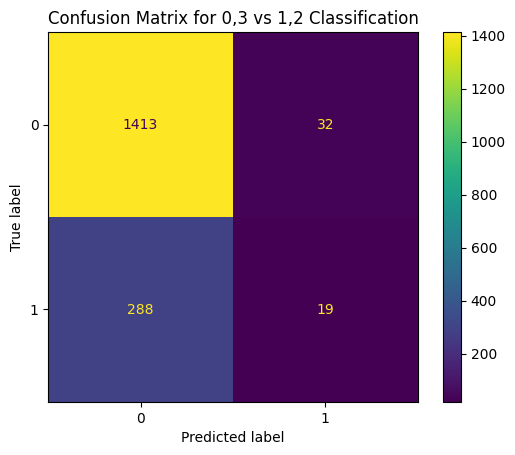

In [43]:

# 0,3 vs 1,2 성능 평가
print("\n===== Stage 1 (0,3 vs 1,2) Performance =====")
y_pred_stage1 = voting_model.predict(x_valid_stage1)

# Precision, Recall, F1-score
print("Classification Report for 0,3 vs 1,2:")
print(classification_report(y_valid_stage1, y_pred_stage1))

# Confusion Matrix 계산 및 시각화
conf_matrix_stage1 = confusion_matrix(y_valid_stage1, y_pred_stage1)

# Confusion Matrix 시각화
ConfusionMatrixDisplay(conf_matrix_stage1, display_labels=[0, 1]).plot()
plt.title("Confusion Matrix for 0,3 vs 1,2 Classification")
plt.show()



===== 0 vs 3 Group Performance =====
Classification Report for 0 vs 3:
              precision    recall  f1-score   support

         0.0       0.51      0.48      0.50       149
         3.0       0.54      0.57      0.55       160

    accuracy                           0.53       309
   macro avg       0.53      0.53      0.53       309
weighted avg       0.53      0.53      0.53       309



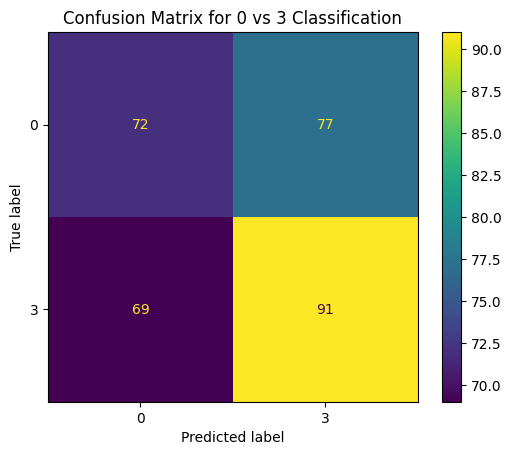

In [44]:
# ===========================================
# 0 vs 3 성능 평가
# ===========================================

print("\n===== 0 vs 3 Group Performance =====")
y_pred_03 = best_stage2_model_03.predict(x_valid_03)

# Precision, Recall, F1-score
print("Classification Report for 0 vs 3:")
print(classification_report(y_valid_03, y_pred_03))

# Confusion Matrix 계산 및 시각화
conf_matrix_03 = confusion_matrix(y_valid_03, y_pred_03)

# Confusion Matrix 시각화
ConfusionMatrixDisplay(conf_matrix_03, display_labels=[0, 3]).plot()
plt.title("Confusion Matrix for 0 vs 3 Classification")
plt.show()


===== 1 vs 2 Group Performance =====
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Classification Report for 1 vs 2:
              precision    recall  f1-score   support

           1       0.51      0.47      0.49       705
           2       0.53      0.57      0.55       738

    accuracy                           0.52      1443
   macro avg       0.52      0.52      0.52      1443
weighted avg       0.52      0.52      0.52      1443



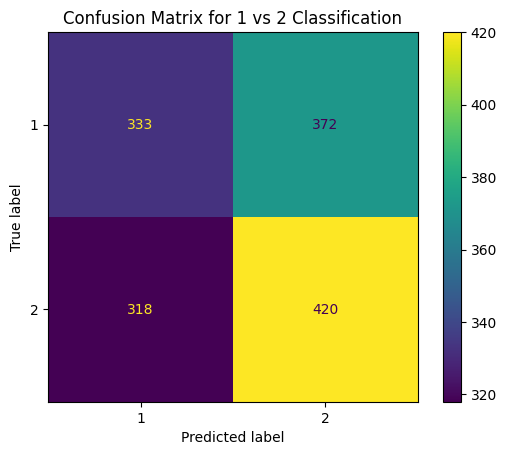

In [45]:
# ===========================================
# 1 vs 2 성능 평가
# ===========================================

print("\n===== 1 vs 2 Group Performance =====")
y_pred_12 = voting_model_12.predict(x_valid_12)

# Precision, Recall, F1-score
print("Classification Report for 1 vs 2:")
print(classification_report(y_valid_12, y_pred_12, target_names=['1', '2']))

# Confusion Matrix 계산 및 시각화
conf_matrix_12 = confusion_matrix(y_valid_12, y_pred_12)

# Confusion Matrix 시각화
ConfusionMatrixDisplay(conf_matrix_12, display_labels=['1', '2']).plot()
plt.title("Confusion Matrix for 1 vs 2 Classification")
plt.show()